# Assignment: More Xarray with El Niño-Southern Oscillation (ENSO) Data

Here will will calculate the NINO 3.4 index of El Nino variabillity and use it to analyze datasets.

First read [this page from NOAA](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst). It tells you the following:

- The Niño 3.4 region is defined as the region between +/- 5 deg. lat, 170 W - 120 W lon.
- Warm or cold phases of the Oceanic Niño Index are defined by a five consecutive 3-month running mean of sea surface temperature (SST) anomalies in the Niño 3.4 region that is above the threshold of +0.5°C (warm), or below the threshold of -0.5°C (cold). This is known as the Oceanic Niño Index (ONI).

(Note that "anomaly" means that the seasonal cycle, also called the "climatology" has been removed.)

Start by importing Numpy, Matplotlib, and Xarray. Set the default figure size to (12, 6).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

plt.rcParams['figure.figsize'] = [12, 6]

### 1. Reproduce the SST curve from the figure below

Use the `sst.mnmean.nc` file that we worked with in class, located at <http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc>.

You don't have to match the stylistic details, or use different colors above and below zero, just the "3mth running mean" curve.

![enso](https://www.ncdc.noaa.gov/monitoring-content/teleconnections/eln-f-pg.gif)

Load the data as an Xarray dataset. Drop the `time_bnds` variable as we did in class and trim the data to 1950 onward for this assignment.

In [2]:
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds = xr.open_dataset(url, drop_variables = ['time_bnds'])
ds = ds.sel(time = slice('1950', '2020'))
ds

<xarray.Dataset> Size: 55MB
Dimensions:  (lat: 89, lon: 180, time: 852)
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2020-12-01
Data variables:
    sst      (time, lat, lon) float32 55MB ...
Attributes: (12/39)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    data_modified:                   2024-11-03
    DODS_EXTRA.Unlimited_Dimension:  time

Now calculate the climatology and the SST anomaly.

In [3]:
# climatology
gb = ds.groupby('time.month')

#SST anolmalies
ds_anom = gb - gb.mean(dim = 'time')

Now reproduce the plot. Keep the rolling 3-month average of the SST anomaly as a DataArray for the next question.

In [4]:
ds_anom_rolling = ds_anom.rolling(time = 3, center = True).mean()
ds_anom_rolling

<xarray.Dataset> Size: 55MB
Dimensions:  (lat: 89, lon: 180, time: 852)
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2020-12-01
    month    (time) int64 7kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float32 55MB nan nan nan nan ... nan nan nan nan

In [5]:
ds_anom_rolling_nino34 = ds_anom_rolling.sel(lat = ['4','2','0','-2','-4']).sel(lon = slice('190', '242'))
average = ds_anom_rolling_nino34['sst'].mean(dim=('lat', 'lon'))

ds_anom_rolling_nino34

<xarray.Dataset> Size: 457kB
Dimensions:  (lat: 5, lon: 26, time: 852)
Coordinates:
  * lat      (lat) float32 20B 4.0 2.0 0.0 -2.0 -4.0
  * lon      (lon) float32 104B 190.0 192.0 194.0 196.0 ... 236.0 238.0 240.0
  * time     (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2020-12-01
    month    (time) int64 7kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float32 443kB nan nan nan nan ... nan nan nan nan

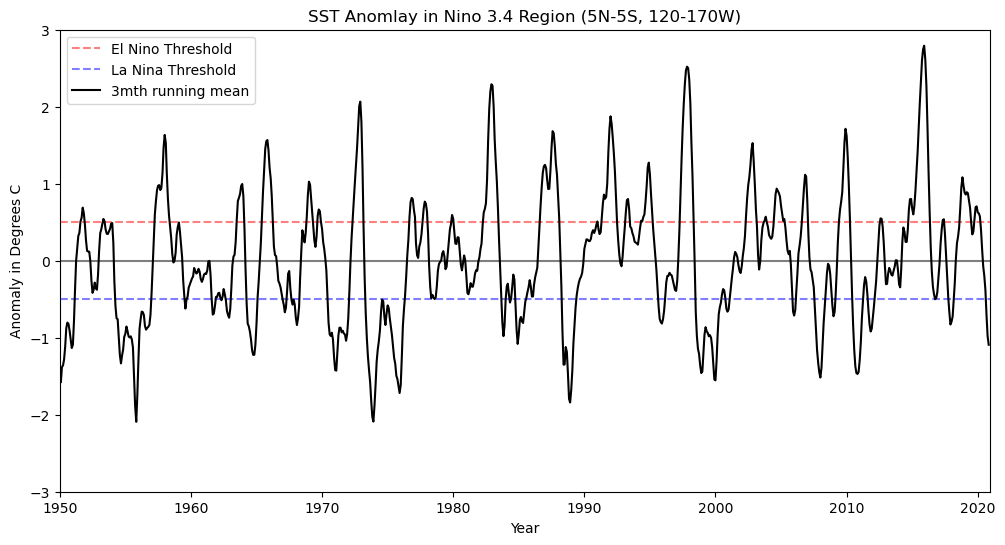

In [6]:
plt.axhline(y = 0, color = 'k', alpha = 0.5)
plt.axhline(y = 0.5, color = 'r', linestyle = '--', label = 'El Nino Threshold', alpha = 0.5)
plt.axhline(y = -0.5, color = 'b', linestyle = '--', label = 'La Nina Threshold', alpha = 0.5)
average.plot(label = '3mth running mean', color = 'k')
plt.xlabel('Year')
plt.ylabel('Anomaly in Degrees C')
plt.title('SST Anomlay in Nino 3.4 Region (5N-5S, 120-170W)')
plt.ylim(-3,3)
plt.xlim(average.time[0], average.time[-1])
plt.legend()

### 2. Calculate boolean timeseries representing the positive / negative ENSO phases

Refer to the definitions of warm/cold phases above.

In [25]:
nino = np.zeros(len(average))

nino[0] = nino[1] = np.sum(average[0:5].values>0.5)==5
nino[-2] = nino[-1] = np.sum(average[-6:-1].values>0.5)==5

for i in range(2,len(average)-2):
    if np.sum(average[i-2:i+3].values>0.5)==5:
        nino[i] = True

nina = np.zeros(len(average))

nina[0] = nina[1] = np.sum(average[0:5].values<-0.5)==5
nina[-2] = nina[-1] = np.sum(average[-6:-1].values<-0.5)==5

for i in range(2,len(average)-2):
    if np.sum(average[i-2:i+3].values<-0.5)==5:
        nina[i] = True

Plot them somehow.

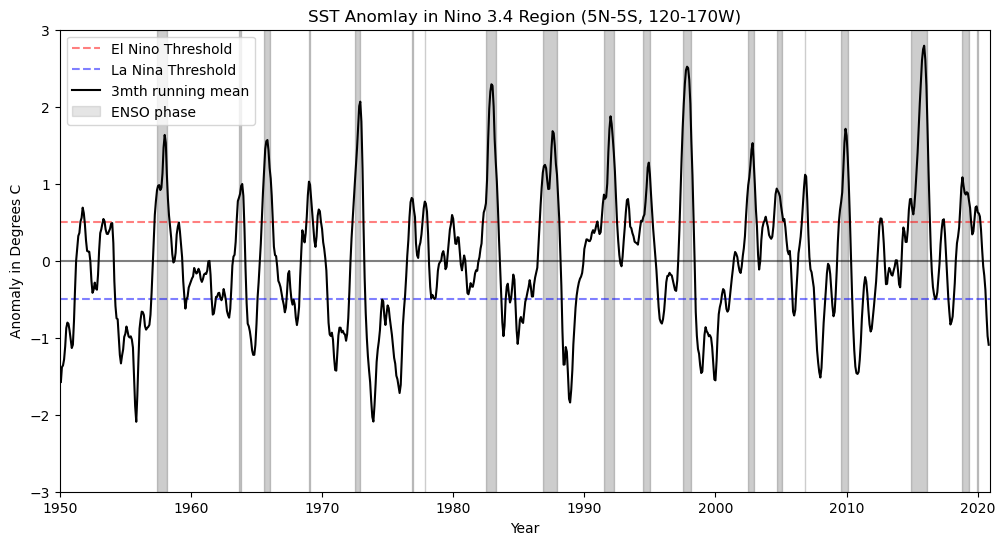

In [22]:
plt.axhline(y = 0, color = 'k', alpha = 0.5)
plt.axhline(y = 0.5, color = 'r', linestyle = '--', label = 'El Nino Threshold', alpha = 0.5)
plt.axhline(y = -0.5, color = 'b', linestyle = '--', label = 'La Nina Threshold', alpha = 0.5)
average.plot(label = '3mth running mean', color = 'k')
plt.xlabel('Year')
plt.ylabel('Anomaly in Degrees C')
plt.title('SST Anomlay in Nino 3.4 Region (5N-5S, 120-170W)')
plt.ylim(-3,3)
plt.xlim(average.time[0], average.time[-1])
plt.fill_between(average.time, -3, 3, where = nino, color = 'k', alpha = 0.1, label = 'ENSO phase')
plt.fill_between(average.time, -3, 3, where = nina, color = 'k', alpha = 0.1)
plt.legend(loc = 'upper left')

plt.show()

### 3. Plot composites of SST anomaly for the positive and negative ENSO regimes

These should be pcolormesh maps. First positive ONI.

Text(0.5, 1.0, 'El Nino Composite')

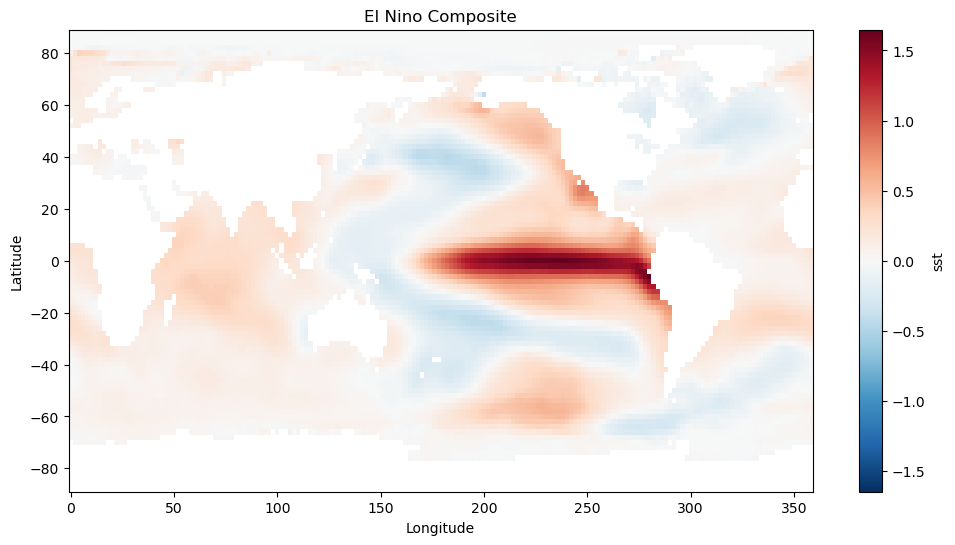

In [27]:
nino_mask = ds_anom_rolling.isel(lat = slice(0,89), lon = slice(0,180), time = nino == 1., drop = True)
nino_comp = nino_mask.mean(dim = 'time', skipna = True)

nino_comp.sst.plot()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('El Nino Composite')

And negative ONI.

Text(0.5, 1.0, 'La Nina Composite')

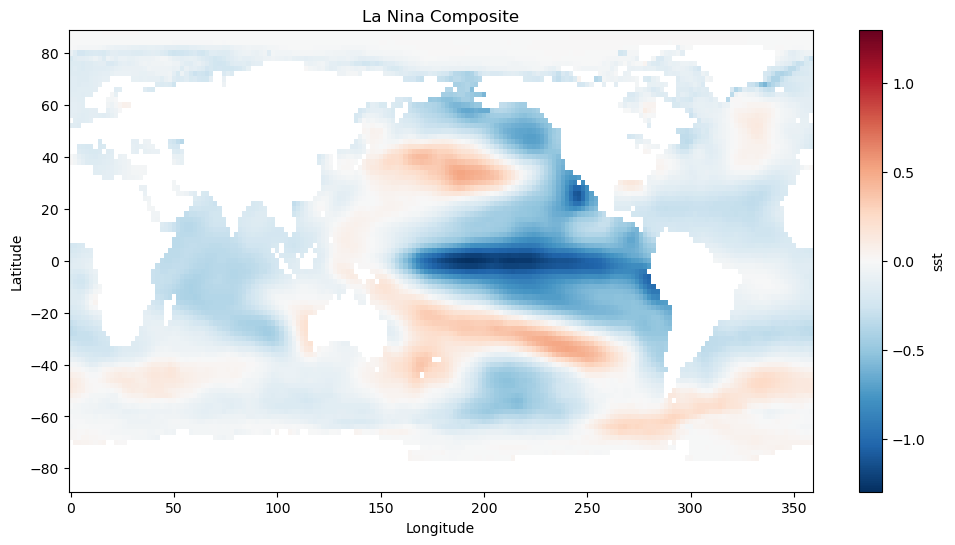

In [28]:
nina_mask = ds_anom_rolling.isel(lat=slice(0,89), lon=slice(0,180), time=nina==1., drop=True)
nina_comp = nina_mask.mean(dim = 'time', skipna = True)

nina_comp.sst.plot()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('La Nina Composite')

### 4. Calculate the composite of preciptiation for positive and negative ENSO phases.

First load the precip dataset. Code to fix the broken time coordinate is included.

In [13]:
import pandas as pd
import xarray as xr
url = 'http://iridl.ldeo.columbia.edu/SOURCES/.NASA/.GPCP/.V2p1/.multi-satellite/.prcp/dods'
dsp = xr.open_dataset(url, decode_times=False)
true_time = (pd.date_range(start='1960-01-01', periods=len(dsp['T']), freq='MS'))
dsp['T'] = true_time
dsp = dsp.rename({'T': 'time'})
dsp.load()

<xarray.Dataset> Size: 15MB
Dimensions:  (X: 144, time: 361, Y: 72)
Coordinates:
  * X        (X) float32 576B 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * time     (time) datetime64[ns] 3kB 1960-01-01 1960-02-01 ... 1990-01-01
  * Y        (Y) float32 288B 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
Data variables:
    prcp     (time, Y, X) float32 15MB nan nan nan ... 0.07234 0.06634 0.06526
Attributes:
    Conventions:  IRIDL

In [56]:
average_prcp = average.sel(time = slice(ds.time[120],ds.time[480])) # slice ssl dataset to have same time range
interp = dsp.interp(X = ds_prcp.lon, Y = ds_prcp.lat, time = ds_prcp.time) # interpolate to coordinates of ssl dataset

In [50]:
# make new booleans for shorter time range

nino_prcp = np.zeros(len(average_prcp))

nino_prcp[0] = nino_prcp[1] = np.sum(average_prcp[0:5].values>0.5)==5
nino_prcp[-2] = nino_prcp[-1] = np.sum(average_prcp[-6:-1].values>0.5)==5

for i in range(2,len(average_prcp)-2):
    if np.sum(average_prcp[i-2:i+3].values>0.5)==5:
        nino_prcp[i] = True

nina_prcp = np.zeros(len(average_prcp))

nina_prcp[0] = nina_prcp[1] = np.sum(average_prcp[0:5].values<-0.5)==5
nina_prcp[-2] = nina_prcp[-1] = np.sum(average_prcp[-6:-1].values<-0.5)==5

for i in range(2,len(average_prcp)-2):
    if np.sum(average_prcp[i-2:i+3].values<-0.5)==5:
        nina_prcp[i] = True

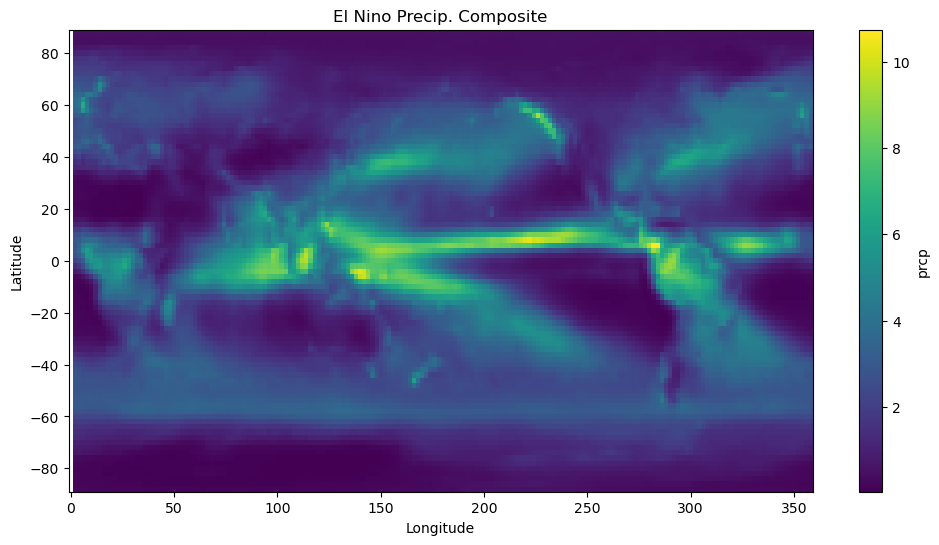

In [57]:
nino_prcp_mask = interp.isel(lat = slice(0,89), lon = slice(0,180), time = nino_prcp == 1., drop = True)
nino_prcp_comp = nino_prcp_mask.mean(dim = 'time', skipna = True)

nino_prcp_comp.prcp.plot()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('El Nino Precip. Composite');

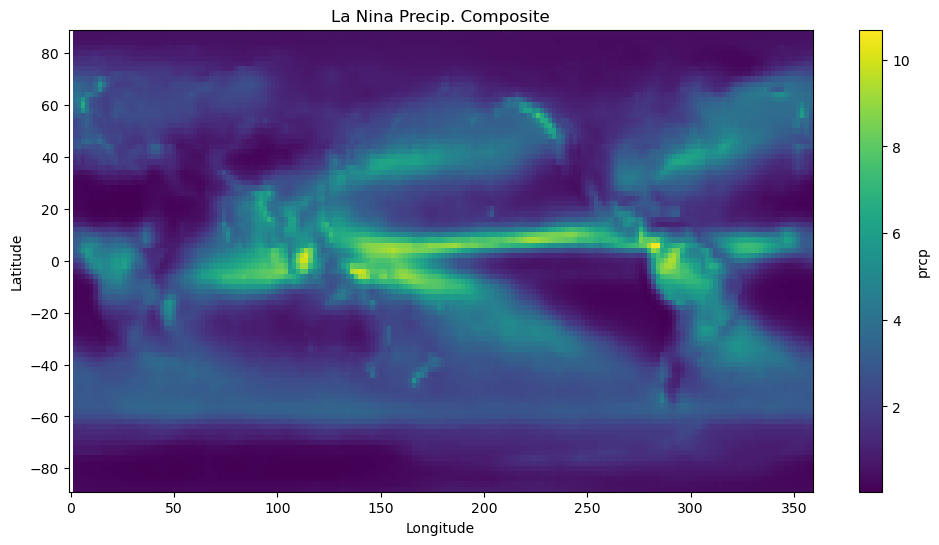

In [58]:
nina_prcp_mask = interp.isel(lat = slice(0,89), lon = slice(0,180), time = nina_prcp == 1., drop = True)
nina_prcp_comp = nina_prcp_mask.mean(dim = 'time', skipna = True)

nina_prcp_comp.prcp.plot()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('La Nina Precip. Composite');

Now plot the *difference* between the time-mean of `prcp` during positive and negative ENSO phases.

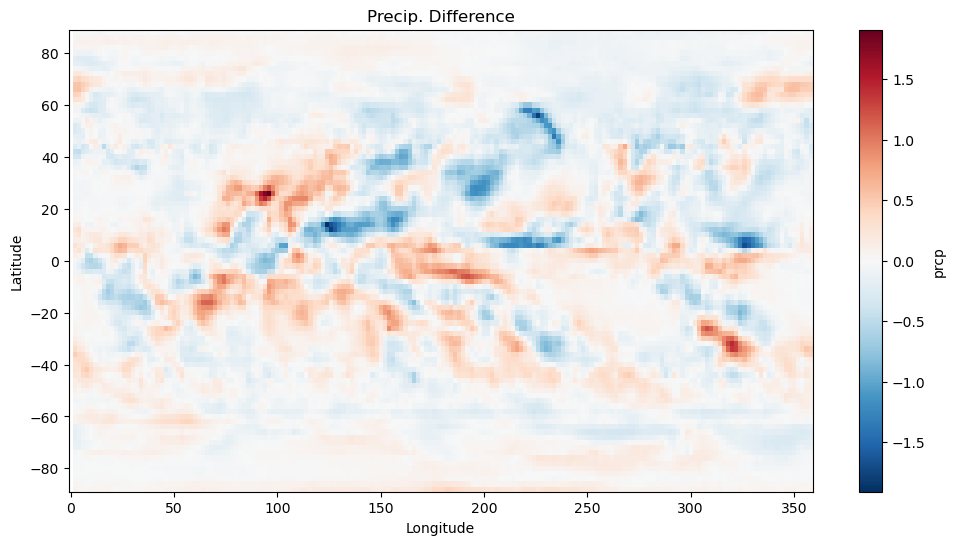

In [61]:
dif = nina_prcp_comp.prcp - nino_prcp_comp.prcp

dif.plot()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Precip. Difference');